In [14]:
import numpy as np
from maxvolpy.maxvol import maxvol
from numpy.polynomial import Chebyshev as T
import numpy.linalg as la
import matplotlib.pyplot as plt
from scipy.linalg import lu as lu
from gen_mat import *
from ids import *
from block_maxvol import *
from block_rect_maxvol import *
import scipy.linalg
from gen_1D import matrix_prep
%matplotlib inline

In [15]:
nder = 2 # dimension
n = 9 # number of points
n_test = 5000 #points on test grid
p_size = (nder+1)*4 #number of monoms (number of columns)
interval = [-1, 1]  # interval of x_test
x = np.random.rand(n, nder)
x_test = np.random.rand(n_test,nder)

In [16]:
c = GenMat(p_size, x,poly=cheb, poly_diff=cheb_diff, debug=False,pow_p=1)
print c.shape
# turn matrix to the block structure
A = matrix_prep(c,nder+1,n)
print A.shape

(27, 12)
(27, 12)


In [17]:
### returns 2 values - function on domain, and block structured
def rhs(points, nder, mode = 'gauss'):
    block_rhs = np.zeros((nder+1)*(points.shape[0]))
    func = 2*np.exp(-((points[:,0]**2)/2. + (points[:,1]**2)/2.))# + (points[:,2]**2)/2.)) # Gaussian
    for i in range(points.shape[0]):
        block_rhs[i*(nder+1)] = func[i]
        for j in range(nder):
            block_rhs[i*(nder+1)+j+1] = -1*(points[i,j])*func[i]
    return func, block_rhs     

#### Information about initial matrix

In [18]:
print la.det(A[:A.shape[1]])
print la.matrix_rank(A)
_,s,_ = scipy.linalg.svd(A)
print s

piv,_ = maxvol(A)
print piv
print la.det(A[piv])

-2.69785219588e-13
12
[ 16.82731063  14.3905272    7.34285041   6.30330136   5.62069268
   3.52351086   1.62453506   0.49765672   0.35546354   0.27750605
   0.08403639   0.02805382]
[ 0 10 11 23 22 20 19 14 13  8  6 25]
-0.77791355038


#### Rectangular block maxvol

In [32]:
k = 18 ### number of rows for LSM
assert k//(nder+1)!=0
assert (k>=A.shape[1])
a,b,final_piv,d,e = rect_block_maxvol(A, nder, Kmax = k, max_iters=100, rect_tol = 0.05, tol = 0.0, debug = False, ext_debug = True)

5
8


In [20]:
### solve LSM
f,t = rhs(x,nder)
A_test = GenMat(p_size, x_test,poly=cheb, poly_diff=cheb_diff, debug=False,pow_p=1)

In [33]:
### Take number of rows that we really need
c = final_piv[:k]

In [22]:
c_block, res_x, rank, s = np.linalg.lstsq(A[c],t[c])

In [23]:
taken_p = x[c[::(nder+1)]/(nder+1),:]

In [26]:
print ("MaxVol error = ", la.norm(rhs(x_test,nder)[0] - np.dot(A_test[:n_test], c_block), np.inf) / la.norm(rhs(x_test,nder)[0], np.inf), "\n")

('MaxVol error = ', 0.047268495637669966, '\n')


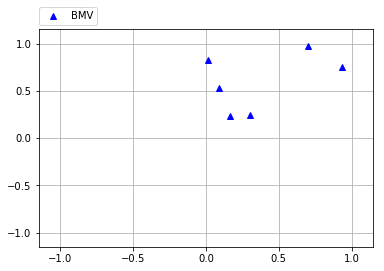

In [27]:
# visualization part
# position of the chosen points by MaxVol and GD in 2-D case
l_bound = interval[0]
u_bound = interval[1]
plt.xlim(l_bound-0.15, u_bound+0.15)
plt.ylim(l_bound-0.15, u_bound+0.15)
#plt.plot(M[row_indx,1], M[row_indx,2], 'ro', label = "MV")
plt.plot(taken_p[:,0],taken_p[:,1], 'b^', label = "BMV")
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, borderaxespad=0.)
plt.grid(True)
plt.show()